In [1]:
import pandas as pd
import numpy as np
import arxivscraper
from random import randint

#### Make authors, papers and authors_paper without rules

WARNING: Running this cell only if you want to extract all the data again, it takes too long

In [2]:
if False:
    # Getting data computer science session
    scraper_cs = arxivscraper.Scraper(category='cs', date_from='2015-08-23',date_until='2017-08-23')
    output = scraper_cs.scrape()
    df = pd.DataFrame.from_dict(output)
    
    # Getting data stat session
    scraper_stat = arxivscraper.Scraper(category='stat', date_from='2015-08-23',date_until='2017-08-23')
    outputs = scraper_stat.scrape()
    df2 = pd.DataFrame.from_dict(outputs)
    
    # generate authors
    authors = []

    output = output[0:len(outputs)]
    for aut in output:
        for i, a in enumerate(aut['authors']):
            authors.append({'idauthor': f'aoz{(i + randint(1,21)*5)}xyz{(i + randint(1,21))}', 'name': a})

    for aut in outputs:
        for i, a in enumerate(aut['authors']):
            authors.append({'idauthor': f'aoz{(i + randint(1,21)*5)}xyz{(i + randint(1,21))}', 'name': a})

    authors
    
    #Generate papers
    papers = []

    for aut in output:
        papers.append({'idpaper': aut['id'], 'title': aut['title'], 'abstract': aut['abstract'], 'date_create': aut['created'], 'area': aut['categories'], 'authors': aut['authors']})

    for aut in outputs:
        papers.append({'idpaper': aut['id'], 'title': aut['title'], 'abstract': aut['abstract'], 'date_create': aut['created'], 'area': aut['categories'], 'authors': aut['authors']})

    papers
    
    # Generate authors_paper
    autor_paper = []

    for p in papers:
        for a in authors:
            if a['name'] in p['authors']:
                autor_paper.append({'idauthor_paper': f'auz{(i + randint(1,21)*5)}ppr{(i + randint(1,21))}', 'author_idauthor': a['idauthor'], 'paper_idpaper': p['idpaper'], 'date_create': p['date_create']})
    autor_paper
    
    # Save .json files
    import json
    with open('../datasets/authors.json', 'w') as fp:
        json.dump(authors, fp)

    with open('../datasets/papers.json', 'w') as fp:
        json.dump(papers, fp)

    with open('../datasets/author_paper.json', 'w') as fp:
        json.dump(autor_paper, fp)

#### Download dataset

#### ** Step initial **
WARNING: This cell should only be executed if it does not have the data on the local machine

In [3]:
if False:
    !wget https://www.dropbox.com/s/s5mysx0b6sp7jvw/authors.json -P ../datasets/
    !wget https://www.dropbox.com/s/ktvn3q2ijfka9zn/authors_paper.json -P ../datasets/
    !wget https://www.dropbox.com/s/jbqvl5htdv41c33/papers.json -P ../datasets/

#### Apply rules

1. Remove papers with only one author
2. All areas that are in year 1 must be in year 2
3. Remove authors who appear in year 1 and do not appear in year 2
4. Remove authors who are only in year 2

In [4]:
if False:
    # load dicts
    import json
    with open('../datasets/authors.json') as fp:
        authors = json.loads(fp.read())

    with open('../datasets/papers.json') as fp:
        papers = json.loads(fp.read())

    with open('../datasets/authors_paper.json') as fp:
        autor_paper = json.loads(fp.read())

    # drop single authors
    papers_with_multiple_authors = []

    for p in papers:
        if len(p['authors']) > 1:
            papers_with_multiple_authors.append(p)

    papers = papers_with_multiple_authors

    # Regenerate authors_paper
    autor_paper = []

    for p in papers:
        for a in authors:
            if a['name'] in p['authors']:
                autor_paper.append({'idauthor_paper': f'auz{(randint(1,21)*5)}ppr{(randint(1,21))}', 'author_idauthor': a['idauthor'], 'paper_idpaper': p['idpaper'], 'date_create': p['date_create']})
    len(autor_paper)

    # Save .json files
    import json
    with open('../datasets/authors.json', 'w') as fp:
        json.dump(authors, fp)

    with open('../datasets/papers.json', 'w') as fp:
        json.dump(papers, fp)

    with open('../datasets/authors_paper.json', 'w') as fp:
        json.dump(autor_paper, fp)

In [7]:
if False:
    from dateutil.relativedelta import relativedelta
    import datetime
    
    # Creates two auxiliary lists with each year's publications
    year_one = []
    year_two = []
    year_limit = datetime.datetime.strptime("2016-08-23", "%Y-%m-%d").timestamp() * 1000

    for ap in autor_paper:
        dt_c = datetime.datetime.strptime(ap['date_create'], "%Y-%m-%d").timestamp() * 1000
        if dt_c > year_limit:
            year_two.append(ap)
        else:
            year_one.append(ap)

    print(len(autor_paper), len(year_two), len(year_one))

    def verify_author_at_year(id_author, list_year):
        for i in list_year:
            if id_author in i['author_idauthor']:
                return True
        return False

    author_paper_on_two_year = []
    single_ids_author = []
    for ap in autor_paper:
        if ap['author_idauthor'] not in single_ids_author:
            single_ids_author.append(ap['author_idauthor'])
            exists_yer_one = verify_author_at_year(ap['author_idauthor'], year_one)
            exists_yer_two = verify_author_at_year(ap['author_idauthor'], year_two)
            if exists_yer_one and exists_yer_two:
                author_paper_on_two_year.append(ap)

    print(len(author_paper_on_two_year))

    # removes non-published authors within two years

    filter_authors = []

    for a in authors:
        for apty in author_paper_on_two_year:
            if a['idauthor'] in apty['author_idauthor']:
                filter_authors.append(a)
                continue

    print(len(authors), len(filter_authors))


    # removes unused papers 

    filter_papers = []

    for p in papers:
        for apty2 in author_paper_on_two_year:
            if p['idpaper'] in apty2['paper_idpaper']:
                filter_papers.append(p)

    print(len(papers), len(filter_papers))

    # Save .json files
    import json
    with open('../datasets/authors.json', 'w') as fp:
        json.dump(filter_authors, fp)

    with open('../datasets/papers.json', 'w') as fp:
        json.dump(filter_papers, fp)

    with open('../datasets/authors_paper.json', 'w') as fp:
        json.dump(author_paper_on_two_year, fp)

4202676 826934 3375742
2536
68640 92755
19683 2569


#### Load dataframes authors

In [17]:
df_authors = pd.read_json('../datasets/authors.json')
df_authors.drop_duplicates(subset=['idauthor'], keep=False, inplace=True)
df_authors.head()

,idauthor,name
404,aoz109xyz32,rossi
1920,aoz107xyz24,han
2626,aoz27xyz28,calandriello
2628,aoz39xyz27,kung
6087,aoz22xyz28,ng


#### Load dataframes author_paper

In [26]:
df_author_paper = pd.read_json('../datasets/authors_paper.json')
df_author_paper.drop_duplicates(subset=['author_idauthor', 'date_create', 'paper_idpaper'], keep=False, inplace=True)
df_author_paper.tail()

,author_idauthor,date_create,idauthor_paper,paper_idpaper
2531,aoz75xyz36,2016-04-02,auz20ppr16,1604.00572
2532,aoz88xyz27,2016-06-14,auz40ppr12,1606.04460
2533,aoz112xyz25,2016-06-14,auz65ppr6,1606.04460
2534,aoz136xyz53,2016-07-25,auz10ppr4,1607.07195
2535,aoz46xyz25,2016-08-16,auz5ppr4,1608.04846


#### Load dataframes paper

In [29]:
df_paper = pd.read_json('../datasets/papers.json')
df_paper.drop(columns=['authors'], axis=1, inplace=True)
df_paper.drop_duplicates(subset=['area', 'idpaper', 'title'], keep=False, inplace=True)
df_paper.head()

,abstract,area,date_create,idpaper,title
1128,a game-theoretic model is proposed to study th...,cs.it math.it,2007-04-30,704.3880,energy-efficient resource allocation in wirele...
1528,an information-theoretic approach is proposed ...,cs.it cs.cr math.it,2007-05-14,705.1919,optimal watermark embedding and detection stra...
1646,"in random-access communication systems, the nu...",cs.it math.it,2007-05-23,705.3344,multiuser detection in a dynamic environment p...
1746,the space-time bit-interleaved coded modulatio...,cs.it math.it,2007-06-15,706.2310,space-time coding techniques with bit-interlea...
1760,this paper considers the problem of secure cod...,cs.it cs.cr math.it,2007-06-25,706.3752,secure nested codes for type ii wiretap channels


#### Extract features with LSA from abstract 

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.externals import joblib

In [31]:
tfidf_vectorizer = TfidfVectorizer(max_features=50000, stop_words="english", use_idf=True, smooth_idf=True)
X = tfidf_vectorizer.fit_transform(df_paper['abstract'])

models = '../models/'

with open(f'{models}tf_idf_vectorize.pkl', 'wb') as mtfidf:
    joblib.dump(tfidf_vectorizer, mtfidf)

svd = TruncatedSVD(n_components=400, algorithm='randomized',
                   n_iter=10)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
lsa.fit_transform(X)

with open(f'{models}lsa.pkl', 'wb') as fin:
    joblib.dump(lsa, fin)

tf_idf = joblib.load(f'{models}tf_idf_vectorize.pkl')

tf_idf_features = tf_idf.transform(df_paper['abstract'])

lsa = joblib.load(f'{models}lsa.pkl')

X = lsa.transform(tf_idf_features)

In [32]:
X

array([[ 0.29890191, -0.032782  ,  0.15921879, ...,  0.0144303 ,
         0.04512589,  0.06330711],
       [ 0.17768014,  0.0927589 , -0.08203369, ..., -0.02460668,
        -0.01800023, -0.00575861],
       [ 0.25304918, -0.08741606, -0.00714932, ..., -0.02840113,
         0.04846352,  0.00649877],
       ..., 
       [ 0.10641563, -0.09915295, -0.09373439, ..., -0.00162932,
        -0.000319  ,  0.00334385],
       [ 0.1587031 , -0.12127197, -0.09587623, ...,  0.01551018,
         0.00962215, -0.01936463],
       [ 0.17015754, -0.12863807, -0.14203677, ...,  0.01840371,
        -0.02288986, -0.00173877]])

#### Clustering K-MEANS Sklearn

In [33]:
def kmeans(data):    
    from sklearn.cluster import KMeans
    %matplotlib inline
    import matplotlib.pyplot as plt
    import seaborn as sns; sns.set()

    model = KMeans(n_clusters=2, verbose=False)
    model.fit(data)

    y_kmeans = model.predict(data)
        
    plt.scatter(data[:, 0], data[:, 1], c=y_kmeans, s=50, cmap='viridis')

    centers = model.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

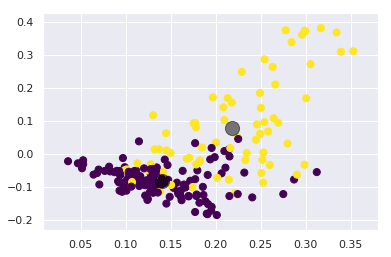

In [34]:
kmeans(X)